# SpoilerDetector

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

We have used a lot of libraries in our project, thats a short description:
- Numpy has been used for the linear algebra operations 
- Pandas has been used for the data processing and the I/O of the data
- NLTK raggroups all the Natural Language Processing techniques 
- Pandarell has been used to parallelize the computation on pandas dataframes 
- Unicode, re and string have been used to process the string 
- Statistics has been used to compute some analysis
- Datatime is a library that includes operations on timestamps
- Contractions has been used to expand contractions in text cleaning

In [3]:
!pip install contractions

     |████████████████████████████████| 287 kB 555 kB/s            
     |████████████████████████████████| 106 kB 7.7 MB/s            


In [4]:
import matplotlib.pyplot as plt # Used to do plots
%matplotlib inline

import nltk 
from nltk.corpus import stopwords # Stopwords 
from nltk.tokenize import word_tokenize # Word_tokenizer
from nltk.stem.porter import PorterStemmer
from pattern.text.en import singularize

from pandarallel import pandarallel # Parallel workers on pandas dataframe

import unidecode
import re 
import time
import string
import statistics

from datetime import datetime

import contractions

In [5]:
stop = stopwords.words('english') # Set of stopwords

words = set(nltk.corpus.words.words()) # Set of meaniningful words

In [6]:
pandarallel.initialize(nb_workers=8) # Describes how much processors to use in pandas parallel computations

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# **DATASET LOADING AND OVERVIEW**

In this section we have performed the operation of loading the dataset and analyze its characteristics. \
We have loaded the dataset from a JSON file using Pandas and analyzed his shape, first n values and columns info.

In [7]:
# Read the json file and load it as dataframe 
df_reviews = pd.read_json('../input/imdb-spoiler-dataset/IMDB_reviews.json', lines=True) 

In [8]:
# Print datasets shape
print('User reviews shape: ', df_reviews.shape)

User reviews shape:  (573913, 7)


In [9]:
# Get an idea about the reviews dataset
df_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [10]:
# Analyze the type of the columns and non-null values of them
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  int64 
 6   review_summary  573913 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 26.8+ MB


# **DATA ANALYSIS**

In this section we have analyzed the data of the dataset in order to better understand how the dataset was composed. 

### Dataset Distribution

First of all we have analyzed how the two classes are distributed in the dataset.

Percentage distribution in the dataset of spoilers and not spoilers 

False    73.7
True     26.3
Name: is_spoiler, dtype: float64


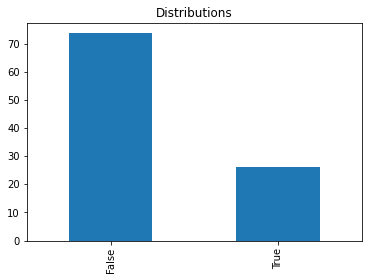

In [11]:
print('Percentage distribution in the dataset of spoilers and not spoilers \n')

# Compute distribution between classes
print(round(df_reviews.is_spoiler.value_counts(normalize=True)*100,2)) 
# Plot distribution between classes 
round(df_reviews.is_spoiler.value_counts(normalize=True)*100,2).plot(kind='bar')

plt.title('Distributions')
plt.show()

As we can see, the dataset is a little imbalanced: 73% of the reviews are not spoiler and 26% of the reviews are spoiler.

### Check missing values

We have analyzed if the dataset had some null values to handle and we didn't found any of them.

In [12]:
# Count missing values for each column
count = df_reviews.isnull().sum().sort_values(ascending=False)

# Compute percentage 
percentage = ((df_reviews.isnull().sum()/len(df_reviews)*100)).sort_values(ascending=False)

# Concatenate count and percentage arrays and print them 
missing_data = pd.concat([count,percentage],axis=1, keys=['Count','Percentage'])

print(missing_data)

                Count  Percentage
review_date         0         0.0
movie_id            0         0.0
user_id             0         0.0
is_spoiler          0         0.0
review_text         0         0.0
rating              0         0.0
review_summary      0         0.0


### Percentage of spoiler for rating level

We have analyzed if the review's rating was a spoiler factor. We have done this operation processing the percentage of spoiler in each of the rating compared to the total number of reviews for each rating.

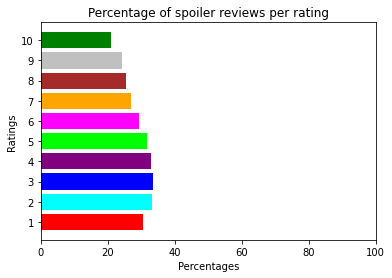

In [13]:
group = df_reviews.groupby('rating') # Groupby rating
 # Get only the spoiler reviews and group them by rating
group_is_spoiler = df_reviews[df_reviews['is_spoiler'] == True].groupby('rating')
tot_review_for_vote = group.size() # Get the number of reviews foreach vote
tot_spoiler_for_vote = group_is_spoiler.size() # Get the number of spoiler review foreach vote
percentage = ((tot_spoiler_for_vote / tot_review_for_vote) * 100) # Compute the %

# Print % graph

y_axis = ['1', '2', '3', '4', '5', '6','7','8','9','10']
x_axis = percentage.tolist()

plt.barh(y_axis,x_axis,color=['red','cyan','blue','purple','lime','magenta','orange','brown','silver','Green'])
plt.xlim(0,100)
plt.title('Percentage of spoiler reviews per rating')
plt.ylabel('Ratings')
plt.xlabel('Percentages')
plt.show()

We have found that with the increase of the rating value the percentage of spoiler decreases a little. 

### Checking spoiler distribution for some selected words 

We have compared some classic spoiler words, which are "spoiler", "die" and "win" in our case, counting the number of spoiler (and not) reviews that contains that word in relation to the total number of reviews in the dataset.

In [14]:
def compare_review_by_word(word,df_reviews):
    
    # Create the name for the column that will be added to the dataset
    column_name = 'contains_word_' + word 
    # Filtering reviews that contains the word "word"
    df_reviews[column_name] = df_reviews['review_text'].apply(lambda x: word.lower() in x.lower()) 
    
    # Count the number of reviews that contains the word "word"
    n_reviews_with_word = df_reviews[df_reviews[column_name] == True].shape[0]
    # Count the number of reviews that are spoiler and contains the word "word"
    spoilers_with_word = df_reviews[(df_reviews['is_spoiler'] == True) & (df_reviews[column_name] == True)].shape[0]
    # Count the number of reviews that are NOT spoiler and contains the word "word"
    not_spoilers_with_word = df_reviews[(df_reviews['is_spoiler'] == False) & (df_reviews[column_name] == True)].shape[0]
    # Count the number of spoilers in total
    total_spoilers = df_reviews[(df_reviews['is_spoiler'] == True)].shape[0]
    
    print("Spoiler reviews that contain the word " + word + ": " + str(spoilers_with_word))
    print("Not spoiler reviews that contain the word " + word + ": " + str(not_spoilers_with_word))
    print("Total number of spoiler reviews: " + str(total_spoilers))
    print("\n--------------------------------------------------------------- \n")
    
    # -------------------------------- #
    
    # Plot the graphs 
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15)) #ax1,ax2 refer to your two pies
    fig.tight_layout(pad = 10.0)
    
    # Graph that compare the number of reviews that are spoiler/not spoiler and contains the word "word"
    labels = ["Spoiler", "Not spoiler"]
    values = np.array([(spoilers_with_word/n_reviews_with_word)*100,(not_spoilers_with_word/n_reviews_with_word)*100 ])
    ax1.pie(values,labels = labels,colors = ['#ff6361','#ffa600'],autopct='%1.2f%%') #plot first pie
    ax1.set_title('Reviews containing the word ' + word)

    # Graph that compare the number of reviews in total that contains/not contains the word "word" 
    labels = ["Containing the word " + word, "Not containing the word " + word]
    values = np.array([(spoilers_with_word/total_spoilers)*100,((total_spoilers - spoilers_with_word)/total_spoilers)*100 ])
    ax2.pie(values,labels = labels,colors = ['#ff6361', '#77B1E0'],autopct = '%1.2f%%') #plot second pie
    ax2.set_title('Spoiler reviews')

    # Remove the column created
    df_reviews = df_reviews.drop([column_name], axis=1)
    
    return df_reviews

Spoiler reviews that contain the word spoiler: 19018
Not spoiler reviews that contain the word spoiler: 7418
Total number of spoiler reviews: 150924

--------------------------------------------------------------- 

Spoiler reviews that contain the word die: 48060
Not spoiler reviews that contain the word die: 92520
Total number of spoiler reviews: 150924

--------------------------------------------------------------- 

Spoiler reviews that contain the word win: 47468
Not spoiler reviews that contain the word win: 96692
Total number of spoiler reviews: 150924

--------------------------------------------------------------- 



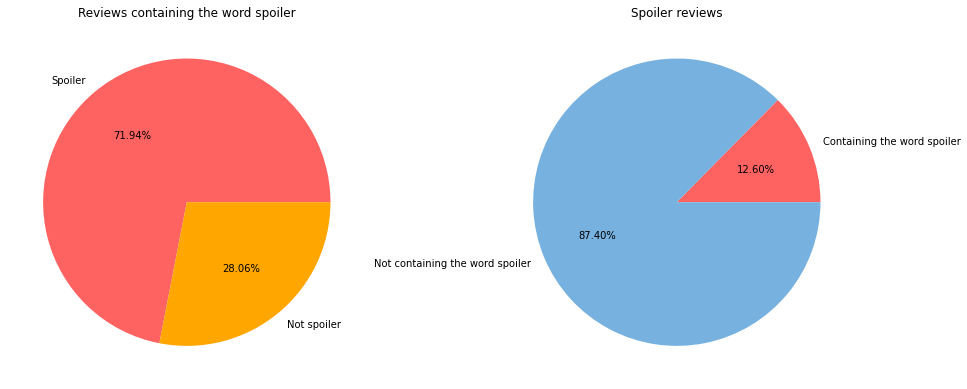

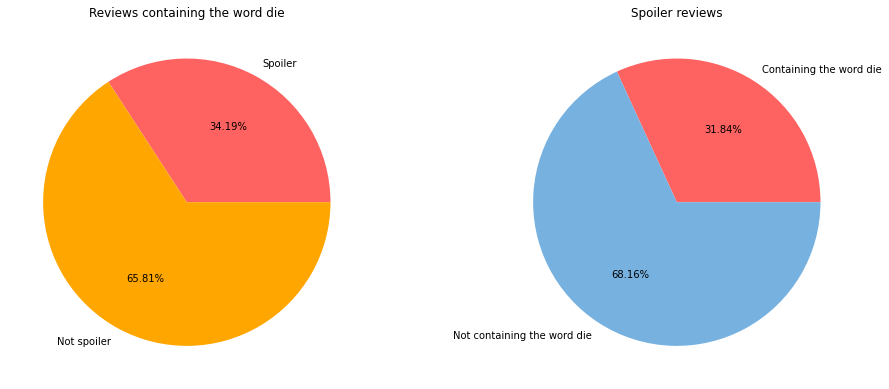

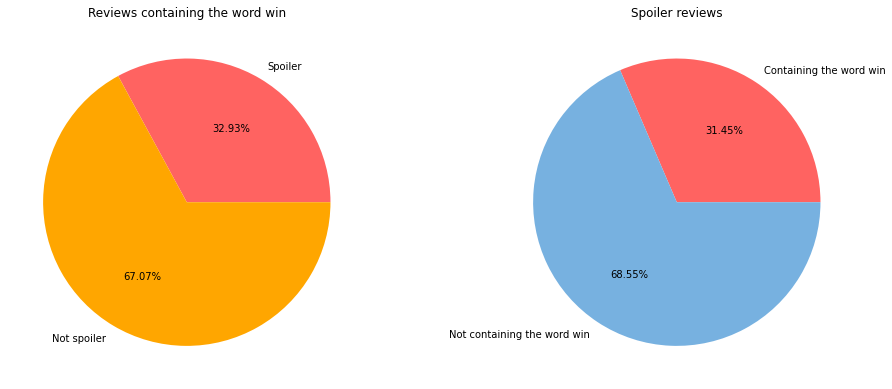

In [15]:
# Plot the pies for words "spoiler", "die" and "win".
df_reviews = compare_review_by_word('spoiler',df_reviews)
df_reviews = compare_review_by_word('die',df_reviews)
df_reviews = compare_review_by_word('win',df_reviews)

On the left of each figure, it's represented the distribution of classes respect to the total number of reviews containing the word. On the right, it's represented the distribution of reviews that contains that words respect to the total number of spoiler reviews in the dataset.

### Average number of words for spoiler and not spoiler reviews

We have analyzed if the review length is a discriminant respect to the spoiler label. We have found that in average the number of words used in the spoiler review is higher than in not spoiler reviews.

avg words for spoiler reviews: 335
avg words for not spoiler reviews: 232


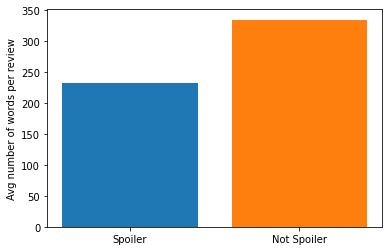

In [16]:
# Compute the number of words foreach review
df_reviews['number_of_words_in_review'] = df_reviews['review_text'].apply(lambda x: len(x.split(" ")))

# Compute the mean for spoiler and not spoiler reviews
avg_length_of_spoilers = df_reviews.groupby('is_spoiler').mean()['number_of_words_in_review']

# Print values
print('avg words for spoiler reviews: ' + str('{:.0f}'.format(avg_length_of_spoilers[1])))
print('avg words for not spoiler reviews: ' + str('{:.0f}'.format(avg_length_of_spoilers[0])))

# ---- PLOT ----- #

plt.bar('Spoiler', avg_length_of_spoilers[0])
plt.bar('Not Spoiler', avg_length_of_spoilers[1])

plt.ylabel('Avg number of words per review')

plt.show()

# Remove the column created
df_reviews = df_reviews.drop(['number_of_words_in_review'], axis=1)



In [17]:
df_reviews_dataset = df_reviews

# **DATA PREPROCESSING**

In this section we have done some text preprocessing operation to transform and clean the text of the reviews. 

### **Data Cleaning**

In [18]:
# Remove links from text
def remove_links(text):
    """
    This function will remove links from the 
    text contained within the Dataset.
       
    arguments:
        input_text: "text" of type "String". 
                    
    return:
        value: "text" with removed links. 
    """
    
    text = re.sub(r'http\S+', '', text)
    return text

In [19]:
# Remove accented characters
def accented_characters_removal(text):
    """
    This function will remove accented characters from the 
    text contained within the Dataset.
       
    arguments:
        input_text: "text" of type "String". 
                    
    return:
        value: "text" with removed accented characters.  
    """
    
    # Unidecode() - It takes unicode data & tries to represent it to ASCII characters. 
    text = unidecode.unidecode(text) 
    
    return text

In [20]:
# Remove repeated characters and punctuations
def reducing_incorrect_character_repeatation(text):
    """
    This Function will reduce repeatition to two characters 
    for alphabets and to one character for punctuations.
    
    arguments:
         input_text: "text" of type "String".
         
    return:
        value: Finally formatted text with alphabets repeating to 
        two characters & punctuations limited to one repeatition 
    """
    
    # Pattern matching for all case alphabets
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    
    # Limiting all the  repeatation to two characters.
    Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
    
    # Pattern matching for all the punctuations that can occur
    Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    
    # Limiting punctuations in previously formatted string to only one.
    Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)
    
    # The below statement is replacing repeatation of spaces that occur more than two times with that of one occurrence.
    Final_Formatted = re.sub(' {2,}',' ', Combined_Formatted)
    
    return Final_Formatted

In [21]:
# Expand contraction words
def expand_contractions(text):
    """
    This Function will expands contractions in words.
    
    arguments:
         input_text: "text" of type "String".
         
    return:
        value: "text" with expanded contractions .  
    """
    
    # creating an empty list
    expanded_words = []    
    for word in text.split():
      # using contractions.fix to expand the shotened words
      expanded_words.append(contractions.fix(word)) 
    
    String_Of_tokens = ' '.join(expanded_words)
    
    return String_Of_tokens

In [22]:
# Remove special characters
def removing_special_characters(text):
    """
    This Function will remove special characters (including punctualization).
    
    arguments:
         input_text: "text" of type "String".
         
    return:
        value: "text" with special characters removed.  
    """
    
    pattern = r"[^a-zA-Z]"
    text = re.sub(pattern,' ', text)
    
    return text

In [23]:
port_stemmer = PorterStemmer() # Creating the stemmer

# Apply Stemming, remove stopwords, remove meaninglessWords
def stemming_stopwords_meaninglessWords(text):
    """
    This Function will remove meaningless words, stopwords and apply stemming.
    
    arguments:
         input_text: "text" of type "String".
         
    return:
        value: "text" with meaningless and stopwords removed, stemming applied. 
    """

    tokens = word_tokenize(text) # Tokenizing the text 
    
    text_1 = ' '.join([
        port_stemmer.stem(token) for token in tokens if token not in stop and singularize(token) in words])
    
    text_2 = ' '.join([
        singularize(token) for token in tokens if token not in stop and singularize(token) in words
        ]) 
        
    return text_1, text_2

In [24]:
# Text cleaning

def text_clean(text):
    
    text = text.lower()
    
    text = remove_links(text)
    
    text = expand_contractions(text)
    
    text = accented_characters_removal(text)
    
    text = removing_special_characters(text)

    text = reducing_incorrect_character_repeatation(text)
    
    text_1, text_2 = stemming_stopwords_meaninglessWords(text)
    
    return text_1, text_2

In [25]:
# Example of text cleaning

example_text = "http://google.com this IS treee okk test fòr text cleaning, isn't it  dsiadohaspidnpas anomalies ?"

print("--- Initial text example ---")
print(example_text,"\n")

print("--- Lower function ---")
example_text = example_text.lower()
print(example_text,"\n")

print("--- Remove_Links function ---")
example_text = remove_links(example_text)
print(example_text,"\n")

print("--- Remove_Links function ---")
example_text = expand_contractions(example_text)
print(example_text,"\n")

print("--- Remove_Accented_Characters function ---")
example_text = accented_characters_removal(example_text)
print(example_text,"\n")

print("--- Remove_Special_Characters function ---")
example_text = removing_special_characters(example_text)
print(example_text,"\n")

print("--- Reduce_Incorrect_Character_Repeatation function ---")
example_text = reducing_incorrect_character_repeatation(example_text)
print(example_text,"\n")

example_text_1, example_text_2 = stemming_stopwords_meaninglessWords(example_text)

print("--- Remove stopwords_meaningLessWord and apply stemming function ---")
print(example_text_1,"\n")

print("--- Remove stopwords_meaningLessWord function -> Don't apply stemming ---")
print(example_text_2,"\n")

--- Initial text example ---
http://google.com this IS treee okk test fòr text cleaning, isn't it  dsiadohaspidnpas anomalies ? 

--- Lower function ---
http://google.com this is treee okk test fòr text cleaning, isn't it  dsiadohaspidnpas anomalies ? 

--- Remove_Links function ---
 this is treee okk test fòr text cleaning, isn't it  dsiadohaspidnpas anomalies ? 

--- Remove_Links function ---
this is treee okk test fòr text cleaning, is not it dsiadohaspidnpas anomalies ? 

--- Remove_Accented_Characters function ---
this is treee okk test for text cleaning, is not it dsiadohaspidnpas anomalies ? 

--- Remove_Special_Characters function ---
this is treee okk test for text cleaning  is not it dsiadohaspidnpas anomalies   

--- Reduce_Incorrect_Character_Repeatation function ---
this is tree okk test for text cleaning is not it dsiadohaspidnpas anomalies  

--- Remove stopwords_meaningLessWord and apply stemming function ---
tree test text clean anomali 

--- Remove stopwords_meaningLe

In [ ]:
%%time
df_reviews_dataset['cleaned_review_stemming'], df_reviews_dataset['cleaned_review'] = zip(*df_reviews_dataset.review_text.parallel_apply(text_clean))

After applying the text clean to the reviews, we could have some reviews that are NaN due to the fact that we remove meaningless words. 
We detect these reviews and we remove from dataset (they are considerated as NaN and not as empty string).

In [27]:
df_reviews_dataset.isna().sum() 

review_date       0
movie_id          0
user_id           0
is_spoiler        0
review_text       0
rating            0
review_summary    0
dtype: int64

In [28]:
df_reviews_dataset = df_reviews_dataset.dropna()

## Handle dates 
We decided to consider the reviews before 2008 as old. \
After that, we toke the last year review (Jan 2017) to build a test set to simulate how the application works with newer reviews. \
We built the training set with the reviews that are beetween 2008 and 2016.

We changed the review_dates format to "Y-m-d"

In [29]:
df_reviews_dataset['review_date'] = pd.to_datetime(df_reviews_dataset['review_date'],format='%d %B %Y')

In [30]:
df_reviews_dataset.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,2006-02-10,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,2000-09-06,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,2001-08-03,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,2002-09-01,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,2004-05-20,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


We built the training set with the reviews that are beetween 2008 and 2016.

In [31]:
# TRAIN SET EXCLUDING DATES < 2008 (TOO OLD) AND > 2016 (USED TO TEST)

train_set = df_reviews_dataset.loc[(df_reviews_dataset['review_date'] < '2017-01-01')
                     & (df_reviews_dataset['review_date'] > '2007-12-31')]

train_set = train_set.drop(['movie_id', 'user_id','rating', 'review_summary'],axis=1)

print("Train set shape: " + str(train_set.shape))
print("Min date: " + str(train_set['review_date'].min()))
print("Max date: " + str(train_set['review_date'].max()))

Train set shape: (288351, 3)
Min date: 2008-01-01 00:00:00
Max date: 2016-12-31 00:00:00


We built the test set with the review that are in the last year (2017)

In [32]:
# TEST SET CONTAINING DATES > 2016

test_set = df_reviews_dataset.loc[(df_reviews_dataset['review_date'] >= '2017-01-01') 
                     & (df_reviews_dataset['review_date'] < '2018-01-01')]

test_set = test_set.drop(['movie_id', 'user_id','rating', 'review_summary'],axis=1)

print("Test set shape: " + str(test_set.shape))
print("Min date: " + str(test_set['review_date'].min()))
print("Max date: " + str(test_set['review_date'].max()))

Test set shape: (45103, 3)
Min date: 2017-01-01 00:00:00
Max date: 2017-12-31 00:00:00


We saved the training and test set.

In [33]:
train_set.to_csv('train_set.csv',index=False)

In [34]:
test_set.to_csv('test_set.csv',index=False)

*** 

In [35]:
df = pd.read_csv('./train_set.csv')

In [36]:
df.shape

(288351, 3)

Divide the dataset in X and y, we load the dataset with stemming to check if the stemming is useful to improve the model measures. 

In [37]:
X = df.cleaned_review
X_stemming = df.cleaned_review_stemming
y = df.is_spoiler

AttributeError: 'DataFrame' object has no attribute 'cleaned_review'

# **MODEL EVALUTATION & SELECTION**

In this section we have performed all the operation needed to evalute and select the model.
As the task is a binary classification problem, we have analyzed the performances of three types of classification models:
- Naive Bayes Multinomial 
- Support Vector Machine
- Logistic Regression 

To do these operations and handle the dataset distribution we have used the sklean and imblearn libraries. \
We have performed the K-cross validation to evalute the model and select it.

In [ ]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import cross_validate

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

### Functions to apply cross-validation and to monitor the classifier measures

In [ ]:
def print_kfold_scores(scores):
    print("Accuracy = ", scores['test_accuracy'])
    print("")
    print("Precision = ", scores['test_precision'])
    print("")
    print("Recall = ", scores['test_recall'])
    print("")
    print("F1 score = ", scores['test_f1_score'])
    print("")
    print("fit_time (s) = ", scores['fit_time'])
    print("")
    print("score_time (s) = ", scores['score_time'])

In [ ]:
def print_cross_validation(score, stemming):
    if stemming:
        print("--------------    K-FOLD WITH STEMMING    --------------\n")
        print_kfold_scores(score)
    else:
        print("--------------    K-FOLD WITHOUT STEMMING    --------------\n")
        print_kfold_scores(score)

In [ ]:
scoring = {
    'accuracy' : make_scorer(accuracy_score), 
    'precision' : make_scorer(precision_score),
    'recall' : make_scorer(recall_score), 
    'f1_score' : make_scorer(f1_score)
}

In [ ]:
from sklearn.model_selection import StratifiedKFold

n_folds = 10
skf = StratifiedKFold(n_folds)

In [ ]:
def apply_cross_validation(clf, X, y, ngrams = (1,1), sampling_ratio = -1, n_jobs = 5, stemming = False):
    '''
    
    '''
    
    if sampling_ratio == -1: 
        clf_pipeline = Pipeline([
            ('vect', TfidfVectorizer(ngram_range=ngrams)),
            ('clf', clf)
        ])
    else:
        clf_pipeline = Pipeline([
            ('vect', TfidfVectorizer(ngram_range=ngrams)),
            ('rus', RandomUnderSampler(sampling_strategy=sampling_ratio)),
            ('clf', clf)
        ])
    
    score = cross_validate(clf_pipeline, X, y, cv = skf, scoring=scoring, n_jobs = n_jobs)
    
    print_cross_validation(score, stemming)
    
    return clf_pipeline, score

## COMPARE MODELS USING DATASET DISTRIBUTION
We have applied the cross-validation with imbalanced-distribution to compare how classifier works on the general dataset and decide which models analyze in more details.

#### MULTINOMIAL

In [ ]:
# Apply cross-validation
clf_pipeline, score = apply_cross_validation(MultinomialNB(), X, y) 

# Register average precision and recall
avg_multinomial_precision = statistics.mean(score['test_precision'])
avg_multinomial_recall = statistics.mean(score['test_recall'])

#### SVM

In [ ]:
# Apply cross-validation
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y)

# Register average precision and recall
avg_svm_precision = statistics.mean(score['test_precision'])
avg_svm_recall = statistics.mean(score['test_recall'])

#### LOGISTIC

In [ ]:
# Apply cross-validation
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y)

# Register average precision and recall
avg_logistic_precision = statistics.mean(score['test_precision'])
avg_logistic_recall = statistics.mean(score['test_recall'])

***

In [ ]:
pd.DataFrame([
    [avg_multinomial_precision, avg_multinomial_recall],
    [avg_svm_precision, avg_svm_recall],
    [avg_logistic_precision, avg_logistic_recall]
], index = ['Multinomial', 'SVM', 'Logistic'], columns=['AVG_Precision', 'AVG_Recall'])

#### COMPARE THE MODELS PLOTTING AVG PRECISION-RECALL

In [ ]:
plt.scatter(avg_multinomial_precision, avg_multinomial_recall, color ='blue')
plt.scatter(avg_svm_precision, avg_svm_recall, color ='orange')
plt.scatter(avg_logistic_precision, avg_logistic_recall, color ='red')
labels = ["multinomial", "svm", "logistic"]

plt.xlim([0, 1]) 
plt.ylim([0, 1]) 

plt.xlabel('precision')
plt.ylabel('recall')

plt.legend(labels=labels)

plt.title('MODEL COMPARISON ON DATASET DISTRIB. MULTINOMIAL/SVM/LOGISTIC \n')

plt.show()

As we can see from the plot, the multinomial model works really bad in terms of precision and recall in respect to the other two classifiers. Due to this, we have decided to perform the analysis changing parameters and distribution only to SVM and Logistic models. 

## COMPARING SVM AND LOGISTIC SCORES 

In this section we have compared the SVM and Logistic model changing parameters of CountVectorizer and the distribution of the classes. We have also analyzed if the stemming is relevant in terms of increasing the model's performances.

### SVM

In [ ]:
from sklearn.svm import LinearSVC
svm_pipelines = []
svm_scores = []

#### Ngram_range (1,1) & Undersampling 50/50

##### With stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y, sampling_ratio = 1)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

##### Without stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, sampling_ratio = 1, stemming = True)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

#### Ngram_range (1,1) & distribution 60 (no spoiler), 40 (spoiler)

##### With stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y, sampling_ratio = (40/60))
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

##### Without stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LinearSVC(), X_stemming, y, sampling_ratio = (40/60), stemming = True)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

#### Ngram_range (1,1) & dataset distribution

##### With stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y, sampling_ratio = -1 )
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

##### Without stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LinearSVC(), X_stemming, y, sampling_ratio = -1, stemming = True)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

#### Ngram_range (1,2) & Undersampling 50/50

##### With stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y, ngrams= (1,2), sampling_ratio = 1)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

##### Without stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LinearSVC(), X_stemming, y, ngrams= (1,2), sampling_ratio = 1, stemming = True)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

### Ngram_range (1,2) & distribution 60 (no spoiler), 40 (spoiler)

##### With stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y, ngrams= (1,2), sampling_ratio = (40/60))
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

##### Without stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LinearSVC(), X_stemming, y, ngrams= (1,2), sampling_ratio = (40/60), stemming = True)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

### Ngram_range (1,2) & dataset distribution

##### With stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LinearSVC(), X, y, ngrams= (1,2), sampling_ratio = -1 )
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

##### Without stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LinearSVC(), X_stemming, y, ngrams= (1,2), sampling_ratio = -1, stemming = True)
svm_pipelines.append(clf_pipeline)
svm_scores.append(score)

### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_pipelines = []
logistic_scores = []

#### Ngram_range (1,1) & Undersampling 50/50

##### With stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y, sampling_ratio = 1)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

##### Without stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, sampling_ratio = 1, stemming = True)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

### Ngram_range (1,1) & distribution 60 (no spoiler), 40 (spoiler)

##### With stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y, sampling_ratio = (40/60))
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

##### Without stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, sampling_ratio = (40/60), stemming = True)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

### Ngram_range (1,1) & dataset distribution

##### With stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y, sampling_ratio = -1 )
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

##### Without stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, sampling_ratio = -1, stemming = True)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

### Ngram_range (1,2) & Undersampling 50/50

##### With stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y, ngrams= (1,2), sampling_ratio = 1)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

##### Without stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, ngrams= (1,2), sampling_ratio = 1, stemming = True)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

### Ngram_range (1,2) & distribution 60 (no spoiler), 40 (spoiler)

##### With stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y, ngrams= (1,2), sampling_ratio = (40/60))
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

##### Without stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, ngrams= (1,2), sampling_ratio = (40/60), stemming = True)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

### Ngram_range (1,2) & dataset distribution

##### With stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X, y, ngrams= (1,2), sampling_ratio = -1 )
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

##### Without stemming

In [ ]:
clf_pipeline, score = apply_cross_validation(LogisticRegression(max_iter=10000), X_stemming, y, ngrams= (1,2), sampling_ratio = -1, stemming = True)
logistic_pipelines.append(clf_pipeline)
logistic_scores.append(score)

***

In [ ]:
indexes=[
    "ngram_1_1-sample5050",
    "ngram_1_1-sample5050_stem",
    "ngram_1_1-sample6040",
    "ngram_1_1-sample6040_stem",
    "ngram_1_1-sampledataset",
    "ngram_1_1-sampledataset_stem",
    "ngram_1_2-sample5050",
    "ngram_1_2-sample5050_stem",
    "ngram_1_2-sample6040",
    "ngram_1_2-sample6040_stem",
    "ngram_1_2-sampledataset",
    "ngram_1_2-sampledataset_stem",
]

def create_df_scores(scores):
    list_scores_precision = []
    list_scores_recall = []
    for x in scores:
        list_scores_precision.append(x['test_precision'])
        list_scores_recall.append(x['test_recall'])      
                                       
    score_df_precision = pd.DataFrame(list_scores_precision, index=indexes)
    score_df_recall = pd.DataFrame(list_scores_recall, index=indexes)
                                       
    score_df_precision['mean'] = score_df_precision.mean(axis=1)
    score_df_recall['mean'] = score_df_recall.mean(axis=1)
    
    score_df = pd.DataFrame([score_df_precision['mean'],score_df_recall['mean']]).T
    score_df.columns = ['avg_precision', 'avg_recall']
    
    return score_df

### SVM SCORES

In [ ]:
svm_df_scores = create_df_scores(svm_scores)
svm_df_scores

### Drop SVM stemming result
We decided to drop the SVM stemming results 'cause it doesn't improve the Accuracy and Precision 

In [ ]:
svm_df_scores = svm_df_scores.drop(index=[
    'ngram_1_1-sample5050_stem',
    'ngram_1_1-sample6040_stem',
    'ngram_1_1-sampledataset_stem',
    'ngram_1_2-sample5050_stem',
    'ngram_1_2-sample6040_stem',
    'ngram_1_2-sampledataset_stem'
])

## LOGISTIC REGRESSION SCORES

In [ ]:
logistic_df_scores = create_df_scores(logistic_scores)
logistic_df_scores

### Drop Logistic stemming result
We decided to drop the Logistic stemming result 'cause it doesn't improve the Accuracy and Precision 

In [ ]:
logistic_df_scores = logistic_df_scores.drop(index=[
    'ngram_1_1-sample5050_stem',
    'ngram_1_1-sample6040_stem',
    'ngram_1_1-sampledataset_stem',
    'ngram_1_2-sample5050_stem',
    'ngram_1_2-sample6040_stem',
    'ngram_1_2-sampledataset_stem'
])

### EXTRACT ONLY RELEVANT RESULTS

We have considered as relevant results the results that had precision and recall > 0.45

In [ ]:
def get_relevant_results(df_precision, df_recall):
    
    indexes_precision = df_precision.loc[(
        df_precision > 0.45
    )].index
    
    indexes_recall = df_recall.loc[(
        df_recall > 0.45
    )].index
    
    indexes = [x for x in indexes_precision if x in indexes_recall]
    
    return indexes

#### SVM RELEVANT RESULTS

In [ ]:
svm_indexes = get_relevant_results(svm_df_scores['avg_precision'], svm_df_scores['avg_recall'])
svm_results = pd.DataFrame([svm_df_scores['avg_precision'].rename('precision'),svm_df_scores['avg_recall'].rename('recall')]).T.loc[svm_indexes]
svm_results

#### LOGISTIC RELEVANT RESULTS

In [ ]:
logistic_indexes = get_relevant_results(logistic_df_scores['avg_precision'], logistic_df_scores['avg_recall'])
logistic_results = pd.DataFrame([logistic_df_scores['avg_precision'].rename('precision'),logistic_df_scores['avg_recall'].rename('recall')]).T.loc[logistic_indexes]
logistic_results

### COMPARISON OF BEST RESULTS OF SVM & LOGISTC

In this subsection we compared the performance of SVM and Logistic after changing some count vectorizer parameters and distribution of class in the train dataset.

In [ ]:
plt.scatter(svm_results['precision'], svm_results['recall'], color ='tab:blue')
plt.scatter(logistic_results['precision'], logistic_results['recall'], color ='tab:orange')

plt.xlim([0.4, 0.6]) 
plt.ylim([0.45, 0.7]) 

plt.xlabel('precision')
plt.ylabel('recall')

plt.legend(labels=['svm','logistic'])

plt.title('MODEL COMPARISON SVM/LOGISTIC')

plt.show()

Since in our application the recall measure is more relevant respect to the precision since it is better to detect a true spoiler review as spoiler than classifying wrong the non-spoiler reviews. \
Even if the SVM gives a result that has precision and recall > 0.5, we decided to get more in details with the Logistic model since it gives the best results in terms of recall and gives acceptable results in terms of precision. 

## LOGISTIC MODEL SELECTION BASED ON PRECISION/RECALL

We have analyzed the best results only for logistic model and decided that the best model in this case is the one with parameters { ngram=(1,2), sample=(50/50)} which has a better recall and gives an acceptable precision.

In [ ]:
colors = ['orange','blue', 'red']

for i in range(logistic_results.shape[0]):
    plt.scatter(logistic_results.precision[i], logistic_results.recall[i], color = colors[i])

plt.xlim([0.45, 0.6]) 
plt.ylim([0.45, 0.7]) 

plt.xlabel('precision')
plt.ylabel('recall')

plt.legend(labels=logistic_results.index)

plt.title('MODEL SELECTION BASED ON PRECISION/RECALL')

plt.show()

# MODEL DEPLOY

With the model selection that we have performed, we can now deploy the model with the parameters chosen.
In this section we will fit the model with all the train dataset and test it with the test set extrapolated in the Data Preprocessing section. \
To remember: The test set is composed with the latests reviews of the original dataset (2017-01) and we will divide them into K-fold (based on month) to evaluate our final model.

In [ ]:
import joblib

In [ ]:
text_clf = Pipeline([
            ('vect', TfidfVectorizer(ngram_range=(1,2))),
            ('rus', RandomUnderSampler(sampling_strategy=(50/50))),
            ('clf', LogisticRegression(max_iter=10000))
        ])

In [ ]:
text_clf.fit(X,y)

### EVALUATE THE MODEL

In [ ]:
# Load the test set
df_test = pd.read_csv('./test_set.csv')

In [ ]:
# Create K-fold based on month division using test dateset

df_test.index = pd.to_datetime(df_test['review_date'],format='%Y-%m-%d')

# Groupby month
group = df_test.groupby(pd.Grouper(freq='M'))

# Divide month value in K-folds
folds = []
group.apply(lambda x: folds.append(pd.DataFrame(x)))

for fold in folds:
    fold.reset_index(drop=True, inplace=True)

#### Test set class distribution

In [ ]:
labels = []
spoiler_list = []
spoiler_distribs = []
not_spoiler_list = []
not_spoiler_distribs = []

for fold in folds:
    # Extract month and year 
    month_year = datetime.strptime(fold['review_date'][0],"%Y-%m-%d").strftime('%Y-%m')
    
    # Number of the total review in the fold
    review_number = len(fold['is_spoiler'])
    
    # Number of spoiler/not spoiler review in the folt 
    spoiler = int(fold['is_spoiler'][fold['is_spoiler']==1].value_counts())
    not_spoiler = int(fold['is_spoiler'][fold['is_spoiler']==0].value_counts())
    
    # Compute distribution 
    spoiler_distrib = spoiler/review_number
    not_spoiler_distrib = not_spoiler/review_number
    
    # List to plot values
    labels.append(month_year)

    spoiler_list.append(spoiler)
    not_spoiler_list.append(not_spoiler)
    
    spoiler_distribs.append(spoiler_distrib)
    not_spoiler_distribs.append(not_spoiler_distrib)

    
# ------ PLOT ------ #
    
width = 0.35
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

ax1.bar(labels, not_spoiler_list, width, label='Not_spoiler')
ax1.bar(labels, spoiler_list, width, bottom=not_spoiler_list, label='Spoiler')

ax1.set_ylabel('Number of instances')
ax1.set_title('Instances by month and spoiler')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()


ax2.bar(labels, not_spoiler_distribs, width, label='Not_spoiler')
ax2.bar(labels, spoiler_distribs, width, bottom=not_spoiler_distribs, label='Spoiler')

ax2.set_ylabel('Monthly distribution of spoilers')
ax2.set_title('Distribution percentage')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.show()

#### Evaluate the model on the K-folds

In [ ]:
test_precision_list = []
test_recall_list = []
labels = []

for fold in folds:
    # Extract month and year 
    month_year = datetime.strptime(fold['review_date'][0],"%Y-%m-%d").strftime('%Y-%m')
    
    # Predict values on the fold 
    y_pred_class = text_clf.predict(fold['cleaned_review'])
    
    # Compute precision and recall on the fold
    precision = precision_score(fold['is_spoiler'], y_pred_class)
    recall = recall_score(fold['is_spoiler'], y_pred_class)
    
    test_precision_list.append(precision)
    test_recall_list.append(recall)
    labels.append(month_year)

# Create dataframe with precision-recall foreach fold
test_scores = pd.DataFrame([test_precision_list, test_recall_list]).T
test_scores.columns = ["Precision", "Recall"]
test_scores.index = labels

test_scores

## EXPORT THE MODEL

In [ ]:
joblib.dump(text_clf, 'SpoilerDetector.pkl')